In [33]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy
import scipy.special as special
import matplotlib.pyplot as plt

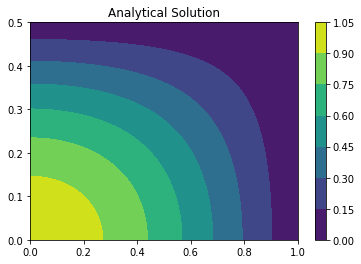

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = 'Data/'

sigma_a = 0.45
sigma_s = 2
sigma_f = 0.5
vsigma_f = 2.5
d = 0.7104
D = 1/(3*(sigma_s + sigma_a))
B_g_square = (vsigma_f - sigma_a)/D
R_e_square = (np.pi**2 + 2.405**2) / B_g_square
R_e = R_e_square ** (1/2)
R = R_e - d
H_e = R_e
AC = 1/special.jv(0,0)


#analytical plot using this function
def Exact_u_func(x,y):
    u = AC*special.jv(0,(2.405/R_e)*x)*np.cos((np.pi/H_e)*y)
    return u

x_pred, y_pred = np.linspace(0,1,100), np.linspace(0,0.5,100)
X, Y = np.meshgrid(x_pred, y_pred)
x_p, y_p = X.flatten(), Y.flatten()
analytical_solution = Exact_u_func(x_p,y_p) 
plt.title('Analytical Solution')
plt.contourf(X,Y,analytical_solution.reshape(100,100),cmap='viridis')
plt.colorbar()

In [35]:
#load collocation points from mat files, generated through latin hypercube samping

X_Res = scipy.io.loadmat(data_path+'X_Res.mat')
x_res = X_Res['x_res']
y_res = X_Res['y_res']
        
X_B = scipy.io.loadmat(data_path+'X_B.mat')
X_b_left = X_B['X_b_left']
X_b_right = X_B['X_b_right']
X_b_down = X_B['X_b_down']
X_b_up = X_B['X_b_up']        
        
        
Boundary = scipy.io.loadmat(data_path+'Boundary.mat')
lb = Boundary['lb']
ub = Boundary['ub']


In [36]:
class PINNS(nn.Module):
    def __init__(self):
        super(PINNS, self).__init__()
        self.layers = [2,40,40,40,40,40,40,40,40,1]
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.linear_layers = nn.ModuleList()
        self.init_linear_layers()
        self.B_g_square = self.data_loader(15.0675)
        
        self.x_res = self.data_loader(x_res)
        self.y_res = self.data_loader(y_res)
        self.lb = self.data_loader(lb,requires_grad=False)
        self.ub = self.data_loader(ub,requires_grad=False)
        self.l_b_1 = self.data_loader(X_b_left[:,0:1])
        self.l_b_2 = self.data_loader(X_b_left[:,1:2])
        self.d_b_1 = self.data_loader(X_b_down[:,0:1])
        self.d_b_2 = self.data_loader(X_b_down[:,1:2])
        self.u_b_x = self.data_loader(X_b_up[:,0:1]) 
        self.u_b_y = self.data_loader(X_b_up[:,1:2]) 
        self.r_b_x = self.data_loader(X_b_right[:,0:1])
        self.r_b_y = self.data_loader(X_b_right[:,1:2])
        
        self.loss_function = torch.nn.MSELoss(reduction='mean')
        self.optimizer = None
        self.iter = 0
        self.start_time = None
    
    
    def data_loader(self,x, requires_grad=True):
        x_array = np.array(x)
        x_tensor = torch.tensor(x_array,
                    requires_grad=requires_grad,
                            dtype=torch.float32,
                            device=device)
        return x_tensor
    
    def loss_func(self,pred,true=None):
        if true is None:
            true = torch.zeros_like(pred).to(self.device)
        return self.loss_function(pred,true)
        
    
    def diff_x(self,a,b):
        da_db = torch.autograd.grad(a.sum(),b,create_graph=True)[0]
        return da_db
    
    def predict(self,x,y):
        x = self.data_loader(x)
        y = self.data_loader(y)
        with torch.no_grad():
            u = self.forward(x,y)
            return u
    
    def adam_optim(self,optimizer,iter):
        self.optimizer = optimizer
        for i in range(iter):
            self.optimize()
            self.optimizer.step()
    
    
    def resize(self,X):
        X_shifted = 2 * (X-self.lb) / (self.ub-self.lb) - 1
        return X_shifted 
    
    def optimize(self):
        if self.start_time is None:
            self.start_time = time.time()
            
        self.optimizer.zero_grad()
    
    
        #loss pde
        x_phy = self.x_res
        y_phy = self.y_res
        l_b_1 = self.l_b_1 
        l_b_2 = self.l_b_2
        d_b_1 = self.d_b_1 
        d_b_2 = self.d_b_2 

        
        pinns_pred = self.forward(x_phy,y_phy)
        phi_x = self.diff_x(pinns_pred,x_phy)
        phi_xx = self.diff_x(phi_x,x_phy)
        phi_y = self.diff_x(pinns_pred,y_phy)
        phi_yy = self.diff_x(phi_y,y_phy)
        eqn = x_phy*(phi_xx + phi_yy + B_g_square*pinns_pred) + phi_x        
        loss_pde = self.loss_func(eqn)
    
        #loss boundary
        bc_left = self.forward(l_b_1,l_b_2) 
        bc_right = self.forward(self.r_b_x,self.r_b_y)
        bc_up = self.forward(self.u_b_x,self.u_b_y)
        bc_down = self.forward(d_b_1,d_b_2) 
        down_grad = self.diff_x(bc_down,d_b_2)
        left_grad = self.diff_x(bc_left,l_b_1)
        
        loss_bc = self.loss_func(down_grad) + self.loss_func(left_grad) + self.loss_func(bc_right) + self.loss_func(bc_up)
        
        #normalisation left, down to equal 1
        x_nor = self.lb[:,0:1]
        y_nor = self.lb[:,1:2]
        norm = self.forward(x_nor,y_nor)
        ones = torch.ones_like(norm).to(self.device)
        loss_norm = self.loss_func(norm,ones)
        a_pde = 1
        a_bc = 1
        a_norm = 1
        self.loss = a_pde*loss_pde + a_bc*loss_bc + a_norm*loss_norm
        self.loss.backward()
        self.iter = self.iter + 1
        
        if self.iter % 10 == 0:
            pde_loss = loss_pde.detach().cpu().numpy()
            bc_loss = loss_bc.detach().cpu().numpy()
            norm_loss = loss_norm.detach().cpu().numpy()
            
            print(f' Iter: {self.iter}, loss_pde: {pde_loss}, loss_bc: {bc_loss}, loss_norm:{norm_loss}')
            elapsed = time.time() - self.start_time
            print(f'Time elapsed: {elapsed}')
            self.start_time = time.time()
            
        return self.loss
    
    def init_linear_layers(self):
        for i in range(len(self.layers) - 1):
            self.linear_layers.append(nn.Linear(self.layers[i], self.layers[i + 1]))
            nn.init.xavier_normal_(self.linear_layers[-1].weight)

    def forward(self, x, y):
        X = torch.cat([x, y], 1)
        X = self.resize(X)
        for layer in self.linear_layers[:-1]:
            X = torch.tanh(layer(X))

        output = self.linear_layers[-1](X)

        return output

In [37]:
t1 = time.time()
NN = PINNS()
NN.to(device)
lr = 1e-4
epochs = 5000

def optimize_predict(lr,epochs):
    adam_optimizer = torch.optim.Adam(NN.parameters(), lr=lr)
    NN.adam_optim(adam_optimizer,epochs)
    
    torch.save(NN.state_dict(), 'cylindrical_pinns.pth')

start_time = time.time()
optimize_predict(lr,epochs=epochs)
print(f'Training total time: {(time.time() - start_time)/60} minutes')

KeyboardInterrupt: 

In [31]:
pred = scipy.io.loadmat('Data/X_Pred.mat')
x_x = pred['x_pred']
y_y = pred['y_pred']

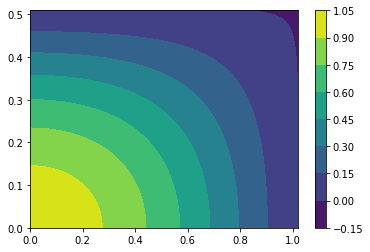

In [32]:
import matplotlib.pyplot as plt
NN = PINNS()
model_path = 'cylindrical_pinns.pth'
NN.load_state_dict(torch.load(model_path, map_location=device))
NN.eval()
NN.to(device)

def data_loader(x,grad=True):
    x_tensor = torch.tensor(x,requires_grad=grad,dtype=torch.float32,device=device)
    return x_tensor

predict_x, predict_y = data_loader(x_x, False).reshape(-1).unsqueeze(1), data_loader(y_y, False).reshape(-1).unsqueeze(1)
with torch.no_grad():
    predictions = NN(predict_x, predict_y)
    
predictions_flattened = predictions.flatten()
plt.contourf(predict_x.reshape(200, 200), predict_y.reshape(200, 200), predictions.reshape(200, 200))
plt.colorbar()